 <img src="img/logo.jpg" alt="drawing" width="650"/>

<center>
    <h1 style="color:gray;font-size:25px;">INFO-F-440 - Algorithms for big data </h1>
</center>

<center>
    <h1 style="font-size:35px;">A Large-Scale k-Nearest Neighbor Classification Algorithm Based  </h1>
</center>


<h1 style="font-size:15px;">Reference  </h1>

Yunsheng Song, Xiaohan Kong, Chao Zhang, "A Large-Scale K-Nearest Neighbor Classification Algorithm Based on Neighbor Relationship Preservation", Wireless Communications and Mobile Computing, vol. 2022, Article ID 7409171, 11 pages, 2022. https://doi.org/10.1155/2022/7409171 

Table Of Contents

1. Loading Packages
2. Loading Functions
3. Select DataSet + Some Results
4. NPR Algorithm + Performances
5. All Algorithms + Performances
6. Annex : Evaluating Algorithm

In [3]:
print('Loading Packages...')

import pandas as pd
import random
import numpy as np
import math 
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from scipy.stats import wilcoxon

import matplotlib.pyplot as plt

import spacialtree as sp


print('Loading Functions...')

class DataProcess:
    def normalize(dataset):
        normalized_df=(dataset.iloc[:,:-1]-dataset.iloc[:,:-1].min())/(dataset.iloc[:,:-1].max()-dataset.iloc[:,:-1].min())
        normalized_df['Target']=dataset.iloc[: , -1]
        return(normalized_df)
    
class Distance:
    def euclidean_distance(row, x):
        distance = 0.0
        for i in range(len(x)):
            distance += (row[i] - x[i])**2
        return math.sqrt(distance)
    
class List:
    def diff_list(list1,list2):
        differences=[]
        for listin in list1:
            if listin not in list2:
                differences.append(listin)
        return differences
    
    def comm_list(list1,list2):
        commons=[]
        for listin in list1:
            if listin in list2:
                commons.append(listin)
        return commons
    
class Clustering:
    def MiniBatch (n,s,data):
        process=data.copy()
        kmeans = MiniBatchKMeans(n_clusters=n, random_state=0, batch_size=s)
        process["Cluster"] = kmeans.fit_predict(process.iloc[: , :-1])
        k_centers=kmeans.cluster_centers_
        
        df_subsets = dict()
        for k, v in process.groupby('Cluster'):
            df_subsets[k] = v
        return(k_centers,df_subsets)
    
class Nearest_Neighbors:
    def knn_cluster(train, test_row, num_neighbors):
        distances = list()
        for j in range(len(train)):
            train_row=train.iloc[j]
            dist = Distance.euclidean_distance(train_row.iloc[:-1],test_row.iloc[:-1])
            distances.append((train_row.iloc[:-1],train_row.iloc[-1], dist))
        distances.sort(key=lambda tup: tup[2])
        neighbors = list()
        values = list()
        for i in range(num_neighbors):
            neighbors.append(distances[i][0].tolist())
            values.append(distances[i][1].tolist())
        return (neighbors,values)
    
    def npr_knn(test_row,subsets,centers,num_neighbors):        
        subsets_tr=subsets.copy() 
        centers_C=centers.copy()
        
        #Initialization: Δ = {0}, k-nearest neighbor set NNk = ∅
        knn_set=list()
        delta=[0]
        
        #while (Δ ≠ ∅ or C ≠ ∅) do
        while len(delta)>0:
            if len(centers_C)>0:
                dist=list()
                knn_set_new=set()
            
                #Find the set Tυ according to the similarity between x and each instance of C, where υ = arg max d(x,c_j) 
                for i in range(len(centers_C)):
                    y=Distance.euclidean_distance(centers_C[i],test_row.iloc[:-1])
                    dist.append(y) 
                index=dist.index(max(dist))
            
                #C = C − {c_v}
                centers_C=np.delete(centers_C, index, 0)   
            
                #Update k-nearest neighbor set NNk of x to generate a new set NNnew by comparing the similarity between x 
                #and each instance of Tυ
                rows=subsets_tr[index].iloc[:,:-1]
                kneighbors_set=Nearest_Neighbors.knn_cluster(rows,test_row,num_neighbors)
                knn_set_new=kneighbors_set[0]
                values=kneighbors_set[1]
            
                #Δ = (NNk − NNnew) U (NNnew − NNk)
                delta=List.diff_list(knn_set,knn_set_new)+List.diff_list(knn_set_new,knn_set)
            
                #NNk = NNnew
                knn_set=knn_set_new
                Y=values
            
                del subsets_tr[index]
                subsets_tr = {i: v for i, v in enumerate(subsets_tr.values())}
            else: break
                
        return (knn_set,Y)
    
    def KD_tree_knn(train,test_row, num_neighbors):
        train_array=np.array(train.iloc[:,:-1].copy())
        spc = sp.spatialtree(train_array,rule='kd')

        test_array=np.array(test_row.iloc[:-1].copy())
        knn_a = spc.k_nearest(train_array, k=num_neighbors, vector=test_array)
        k_neigh=list()
        values=list()
        for i in range(num_neighbors):
            index=knn_a[i]
            k_neigh.append(list(train.iloc[index,:-1]))
            values.append(train.iloc[index,-1])  
        return(k_neigh,values)
    
    def PCA_tree_knn(train,test_row, num_neighbors):
        train_array=np.array(train.iloc[:,:-1].copy())
        spc = sp.spatialtree(train_array,rule='pca')

        test_array=np.array(test_row.iloc[:-1].copy())
        knn_a = spc.k_nearest(train_array, k=num_neighbors, vector=test_array)
        k_neigh=list()
        values=list()
        for i in range(num_neighbors):
            index=knn_a[i]
            k_neigh.append(list(train.iloc[index,:-1]))
            values.append(train.iloc[index,-1])  
        return(k_neigh,values)

class Performances:
    def make_prediction(knn_set):
        output_values = [row for row in knn_set]
        prediction= max(set(output_values), key=output_values.count)
        return prediction
    
    
print("Done.")

Loading Packages...
Loading Functions...
Done.


In [4]:
print('Loading Algorithm Function...')

def algorithms_knn (train,test,size_subset,method='npr',training_ratio=False,testing_ratio=False,accuracy=False):
    k=7 #Numbers of Neighbors - FIXED
    acc=None
    training=None
    testing=None    
    
    if method=='npr' or method == 'all':
        classes=len(train.iloc[: , -1].unique()) #Number of Classes - KINDA FIXED
        minibatch=Clustering.MiniBatch(classes,size_subset,train)
        centers=minibatch[0]
        subsets=minibatch[1]
    n=0
    n_npr=0
    n_mkd=0
    n_pca=0
    
    tr_n=0
    tr_n_npr=0
    tr_n_mkd=0
    tr_n_pca=0       
    
    #Training and Validating
    predictions=list()
    predictions_npr=list()
    predictions_mkd=list()
    predictions_pca=list()
    predictions_knn=list()
    start = time.time()
    for i in range(len(test)):
        if testing_ratio==True or accuracy==True:
            classic_knn=Nearest_Neighbors.knn_cluster(train, test.iloc[i,:], k)
            classic_knn_neigh=classic_knn[0]
            if accuracy == True:
                predictions_knn.append(Performances.make_prediction(classic_knn[1]))
        if method == 'npr':
            npr_knn_result=Nearest_Neighbors.npr_knn(test.iloc[i,:],subsets,centers, k)
            predictions.append(Performances.make_prediction(npr_knn_result[1]))
            if testing_ratio==True:
                npr_knn_neigh=npr_knn_result[0]
                length = List.comm_list(classic_knn_neigh,npr_knn_neigh)
                if(len(length)==7):
                    n+=1
                    
        if method == 'mkd':
            start = time.time()
            mkd_knn_result=Nearest_Neighbors.KD_tree_knn(train,test.iloc[i,:],k)
            predictions.append(Performances.make_prediction(mkd_knn_result[1]))
            if testing_ratio==True:
                mkd_knn_neigh=mkd_knn_result[0]
                length = List.comm_list(classic_knn_neigh,mkd_knn_neigh)
                if(len(length)==7):
                    n+=1  

        if method == 'pca':
            start = time.time()
            pca_knn_result=Nearest_Neighbors.PCA_tree_knn(train,test.iloc[i,:],k)
            predictions.append(Performances.make_prediction(pca_knn_result[1]))
            if testing_ratio==True:
                pca_knn_neigh=pca_knn_result[0]
                length = List.comm_list(classic_knn_neigh,pca_knn_neigh)
                if(len(length)==7):
                    n+=1
                    
        if method == 'all': 
            npr_knn_result=Nearest_Neighbors.npr_knn(test.iloc[i,:],subsets,centers, k)
            mkd_knn_result=Nearest_Neighbors.KD_tree_knn(train,test.iloc[i,:],k)
            pca_knn_result=Nearest_Neighbors.PCA_tree_knn(train,test.iloc[i,:],k)
           
            predictions_npr.append(Performances.make_prediction(npr_knn_result[1]))
            predictions_mkd.append(Performances.make_prediction(mkd_knn_result[1]))
            predictions_pca.append(Performances.make_prediction(pca_knn_result[1]))
            
            if testing_ratio==True: 
                npr_knn_neigh=npr_knn_result[0]
                mkd_knn_neigh=mkd_knn_result[0]
                pca_knn_neigh=pca_knn_result[0]
                length_npr = List.comm_list(classic_knn_neigh,npr_knn_neigh)
                length_mkd = List.comm_list(classic_knn_neigh,mkd_knn_neigh)
                length_pca = List.comm_list(classic_knn_neigh,pca_knn_neigh)
                if(len(length_npr)==7):
                    n_npr+=1
                if(len(length_mkd)==7):
                    n_mkd+=1
                if(len(length_pca)==7):
                    n_pca+=1 
    end = time.time()
    print("The time of execution of", method," is :", end-start) 
                    
    if training_ratio==True:
        print("Training Ratio")
        #Training and Validating
        start = time.time()
        for j in range(len(train)):
            tr_classic_knn_neigh=Nearest_Neighbors.knn_cluster(train, train.iloc[j,:], k)[0]
            if method == 'npr':
                tr_npr_knn_result=Nearest_Neighbors.npr_knn(train.iloc[j,:],subsets,centers, k)
                tr_npr_knn_neigh=tr_npr_knn_result[0]
                tr_length = List.comm_list(tr_classic_knn_neigh,tr_npr_knn_neigh)
                if(len(tr_length)==7):
                    tr_n+=1 
                
            if method == 'mkd':
                start = time.time()
                tr_mkd_knn_result=Nearest_Neighbors.KD_tree_knn(train,train.iloc[j,:],k)
                tr_mkd_knn_neigh=tr_mkd_knn_result[0]
                tr_length = List.comm_list(tr_classic_knn_neigh,tr_mkd_knn_neigh)
                if(len(tr_length)==7):
                    tr_n+=1 
            
            if method == 'pca':
                start = time.time()
                tr_pca_knn_result=Nearest_Neighbors.PCA_tree_knn(train,train.iloc[j,:],k)
                tr_pca_knn_neigh=tr_pca_knn_result[0]
                tr_length = List.comm_list(tr_classic_knn_neigh,tr_pca_knn_neigh)
                if(len(tr_length)==7):
                    tr_n+=1
                    
            if method == 'all':  
                start = time.time()
                tr_npr_knn_result=Nearest_Neighbors.npr_knn(train.iloc[j,:],subsets,centers,k)
                tr_npr_knn_neigh=tr_npr_knn_result[0]
            
                tr_length_npr = List.comm_list(tr_classic_knn_neigh,tr_npr_knn_neigh)
            
                tr_mkd_knn_result=Nearest_Neighbors.KD_tree_knn(train,train.iloc[j,:],k)
                tr_mkd_knn_neigh=tr_mkd_knn_result[0]
            
                tr_length_mkd = List.comm_list(tr_classic_knn_neigh,tr_mkd_knn_neigh)
            
                tr_pca_knn_result=Nearest_Neighbors.PCA_tree_knn(train,train.iloc[j,:],k)
                tr_pca_knn_neigh=tr_pca_knn_result[0]
            
                tr_length_pca = List.comm_list(tr_classic_knn_neigh,tr_pca_knn_neigh)
      
                if(len(tr_length_npr)==7):
                    tr_n_npr+=1
                if(len(tr_length_mkd)==7):
                    tr_n_mkd+=1
                if(len(tr_length_pca)==7):
                    tr_n_pca+=1 
        end = time.time()
        print("The time of execution of", method,"(Training) is :", end-start) 
    #Results
    print('Calculating Results...')
    if method == 'all':
        column=['NPR','MKD','PCA']
        if training_ratio==True:
            train_npr=tr_n_npr/len(train)
            train_mkd=tr_n_mkd/len(train)
            train_pca=tr_n_pca/len(train)
            training={column[0]:train_npr,column[1]:train_mkd,column[2]:train_pca}
            print("NPR - Training Ratio: ",training[column[0]])
            print("MKD - Training Ratio: ",training[column[1]])
            print("PCA - Training Ratio: ",training[column[2]])
        
        if testing_ratio==True:
            test_npr=n_npr/len(test)
            test_mkd=n_mkd/len(test)
            test_pca=n_pca/len(test)
            testing={column[0]:test_npr,column[1]:test_mkd,column[2]:test_pca}
            print("NPR - Testing Ratio: ",testing[column[0]])
            print("MKD - Testing Ratio: ",testing[column[1]])
            print("PCA - Testing Ratio: ",testing[column[2]])
        
        if accuracy==True:
            acc_npr=accuracy_score(test.iloc[:,-1],predictions_npr)
            acc_mkd=accuracy_score(test.iloc[:,-1],predictions_mkd)
            acc_pca=accuracy_score(test.iloc[:,-1],predictions_pca)
            acc_knn=accuracy_score(test.iloc[:,-1],predictions_knn)
            acc={column[0]:acc_npr,column[1]:acc_mkd,column[2]:acc_pca,'KNN':acc_knn}
            print("KNN - Accuracy Score: ",acc['KNN'])
            print("NPR - Accuracy Score: ",acc[column[0]])
            print("MKD - Accuracy Score: ",acc[column[1]])
            print("PCA - Accuracy Score: ",acc[column[2]])
        predictions={column[0]:predictions_npr,column[1]:predictions_mkd,column[2]:predictions_pca}

    else:
        column=[method]
        if training_ratio==True:
            train_match=tr_n/len(train)
            training={column[0]:train_match}
            print(method.upper()," -","Training Ratio: ",training[column[0]])
        if testing_ratio==True:
            test_match=n/len(test)
            testing={column[0]:test_match}
            print(method.upper()," -","Testing Ratio: ",testing[column[0]])
        if accuracy==True:
            acc_knn=accuracy_score(test.iloc[:,-1],predictions_knn)
            acc={method:accuracy_score(test.iloc[:,-1],predictions),'KNN':acc_knn}
            print("KNN - Accuracy Score: ",acc['KNN'])
            print(method.upper()," -","Accuracy Score: ", acc[method])
        predictions={column[0]:predictions}
    
    return(pd.DataFrame(predictions),pd.DataFrame(acc, index=[0]),pd.DataFrame(testing, index=[0]),pd.DataFrame(training, index=[0]))
    
print("Done.")

Loading Algorithm Function...
Done.


<p style="font-size:16px;">   
The algorithm was evaluated on 3 different datasets:
</p>


|     Name       | Number Of Classes   |  Number Of Features   |Training Set Size  |Test Set Size  |
|:----------:|-------------------|-----------------|-------------------|-----------------|
|**Breast Cancer** | 2  |30  | 341 (Split 60-40) | 228 (Split 60-40)|
|**Vehicle** | 4  |18  | 507 (Split 60-40) | 339 (Split 60-40)|
|**DNA** |  3  |180  | 2.000 | 1.186|

<center>
<strong>Source</strong> StatLog
    </center>

#### SUMMARIZE ALGORITHM PERFORMANCE JUST TO HAVE A GENERAL IDEA (table)

## (SELECTION OF A DATASET)

In [11]:
dataset_name = input('Choose a number (from 1 to 3) based on the list above to select one of the datasets: ')
dataset_names=['Breast-Cancer', 'Vehicle', 'DNA']
index=int(dataset_name)
if index == 1:    
    print()
    print('You choose : ',dataset_names[index-1],'DataSet')
    #BREAST-CANCER
    database = load_breast_cancer()
    dataset = pd.DataFrame(data=database.data, columns=database.feature_names)
    dataset['target'] = database.target
    df,test=train_test_split(dataset,test_size=0.4)
if index == 2:  
    print()
    print('You choose : ',dataset_names[index-1],'DataSet')
    #VEHICLE
    dataset=pd.read_csv('data\dataset_vehicle.csv')
    dataset=dataset.set_axis(dataset.iloc[:,0], axis=0).iloc[:,1:len(dataset)]
    df,test=train_test_split(dataset,test_size=0.4)

if index == 3:   
    print()
    print('You choose : ',dataset_names[index-1],'DataSet')
    #DNA
    dataset_tr=pd.read_csv('data\dataset_dna.csv')
    dataset_tr=dataset_tr.set_axis(dataset_tr.iloc[:,0], axis=0).iloc[:,1:len(dataset_tr)]
    dataset_ts=pd.read_csv('data\dataset_dna (testing).csv')
    dataset_ts=dataset_ts.set_axis(dataset_ts.iloc[:,0], axis=0).iloc[:,1:len(dataset_ts)]
    df=dataset_tr
    test=dataset_ts
    
elif index > 3 or index < 1:
    print()
    print('No DataSet found')

Choose a number (from 1 to 3) based on the list above to select one of the datasets: 2

You choose :  Vehicle DataSet


<p style="font-size:16px;">   
As mentioned in the paper, the selected dataset has been scaled to the interval [0,1]. 
</p>

In [14]:
train_set=DataProcess.normalize(df)
test_set=DataProcess.normalize(test)

In [26]:
#Parameter
size_subset=input('Choose the size of the subset for the MKC algorithm (e.g. 500,1000,2000,5000): ')


#Algorithm
predictions,accuracy,testing,training=algorithms_knn(train_set,test_set,int(size_subset),method='npr',accuracy=True)

Choose the size of the subset for the MKC algorithm (e.g. 500,1000,2000,5000): 100


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


The time of execution of npr  is : 85.53188419342041
Calculating Results...
KNN - Accuracy Score:  0.6430678466076696
NPR  - Accuracy Score:  0.6342182890855457


## EVALUATION OF THE ALGORITHM : RUN TIME & PERFORMANCES COMPARISON

Model : RAM -> Simply BigO notation

Here’s the basic framework for approximating the runtime:

    Run the program with a small input size, record how long it takes to run.
    Run the program with a larger input, by about an order of magnitude.
    Repeat (2) until the program starts taking a long time to complete.
    Fit the data with a curve-fitting library.
    Take the largest term in the fitted function, that’s (roughly) your big-O.

In [21]:
df_subsets=dict()
test_subsets=dict()

#BREAST-CANCER
database = load_breast_cancer()
dataset = pd.DataFrame(data=database.data, columns=database.feature_names)
dataset['target'] = database.target
df,test=train_test_split(dataset,test_size=0.4) 
df_subsets[0]=df
test_subsets[0]=test

#VEHICLE
dataset=pd.read_csv('data\dataset_vehicle.csv')
dataset=dataset.set_axis(dataset.iloc[:,0], axis=0).iloc[:,1:len(dataset)]
df,test=train_test_split(dataset,test_size=0.4)
df_subsets[1]=df
test_subsets[1]=test
      
#DNA
dataset_tr=pd.read_csv('data\dataset_dna.csv')
dataset_tr=dataset_tr.set_axis(dataset_tr.iloc[:,0], axis=0).iloc[:,1:len(dataset_tr)]
dataset_ts=pd.read_csv('data\dataset_dna (testing).csv')
dataset_ts=dataset_ts.set_axis(dataset_ts.iloc[:,0], axis=0).iloc[:,1:len(dataset_ts)]
df=dataset_tr
test=dataset_ts
df_subsets[2]=df
test_subsets[2]=test


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 0.14522337913513184
Calculating Results...
The time of execution of above program is : 0.32039356231689453


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 1.2129151821136475
Calculating Results...
The time of execution of above program is : 1.392496109008789


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 12.871692180633545
Calculating Results...
The time of execution of above program is : 13.03586220741272


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 27.312015056610107
Calculating Results...
The time of execution of above program is : 27.473504781723022


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 0.1453549861907959
Calculating Results...
The time of execution of above program is : 0.3079946041107178


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 1.24515700340271
Calculating Results...
The time of execution of above program is : 1.4149911403656006


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 12.084088325500488
Calculating Results...
The time of execution of above program is : 12.24488878250122


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 29.17399501800537
Calculating Results...
The time of execution of above program is : 29.333788871765137


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 0.1515519618988037
Calculating Results...
The time of execution of above program is : 0.30246591567993164


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 1.3378140926361084
Calculating Results...
The time of execution of above program is : 1.49931001663208


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 12.663632154464722
Calculating Results...
The time of execution of above program is : 12.816490650177002


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 44.16325616836548
Calculating Results...
The time of execution of above program is : 44.308615922927856


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 0.15497255325317383
Calculating Results...
The time of execution of above program is : 0.30504894256591797


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 1.3098781108856201
Calculating Results...
The time of execution of above program is : 1.4548304080963135


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 12.589837551116943
Calculating Results...
The time of execution of above program is : 12.73997187614441


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 42.529717683792114
Calculating Results...
The time of execution of above program is : 42.6720609664917


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 1.9429595470428467
Calculating Results...
The time of execution of above program is : 2.131115674972534


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 19.58470320701599
Calculating Results...
The time of execution of above program is : 19.781495094299316


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 196.63057208061218
Calculating Results...
The time of execution of above program is : 196.8209707736969


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 1935.8322212696075
Calculating Results...
The time of execution of above program is : 1936.0202627182007


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


The time of execution of npr  is : 1.938392162322998
Calculating Results...
The time of execution of above program is : 2.330186128616333


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


The time of execution of npr  is : 18.733803272247314
Calculating Results...
The time of execution of above program is : 19.149179220199585


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


The time of execution of npr  is : 190.66006326675415
Calculating Results...
The time of execution of above program is : 191.04805850982666


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


The time of execution of npr  is : 1875.917083978653
Calculating Results...
The time of execution of above program is : 1876.2995781898499


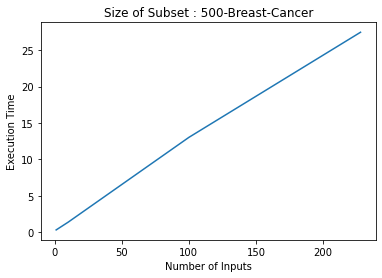

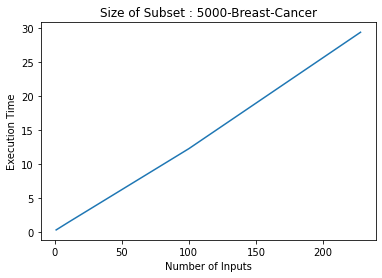

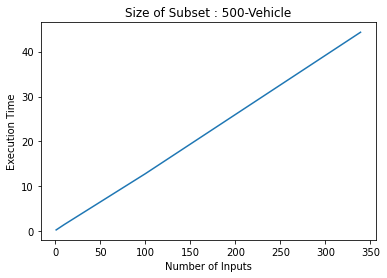

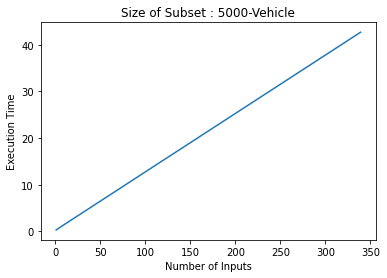

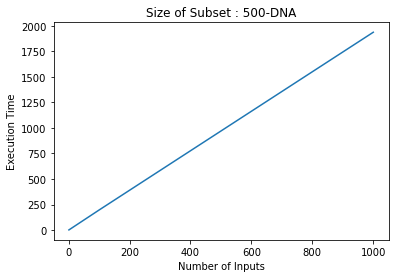

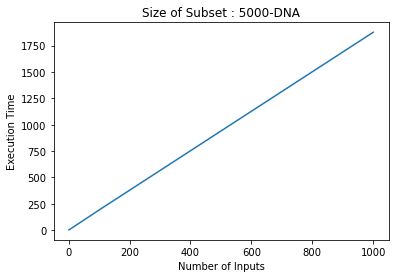

In [22]:
#TIME COMPLEXITY - NPR
names=dataset_names=['Breast-Cancer', 'Vehicle', 'DNA']
for j in range(len(names)):
    name=names[j]
    train_set=DataProcess.normalize(df_subsets[j])
    test_set=DataProcess.normalize(test_subsets[j])
    size=[500,5000]
    
    if len(test_set)<1000:
        last=len(test_set)
    else:
        last=1000
        
    for s in size:
        x=[1,10,100,last]
        y=list()
        for k in x:
            start = time.time()
            perf=algorithms_knn(train_set,test_set.iloc[0:k,:],s,method='npr')
            end = time.time()
            y.append(end-start)
            print("The time of execution of above program is :", end-start)
        plt.figure()
        plt.plot(x,y)
        plt.xlabel('Number of Inputs')
        plt.ylabel('Execution Time')
        plt.title('Size of Subset : ' + str(s) + '-'+ str(name) )
        plt.savefig(str(name)+'_'+str(s) +'.png')
        pd.DataFrame([x,y]).to_csv(r"npr\_" + str(name) +'_'+  str(s)+'.csv')
    

In [25]:
#PERFORMANCES - COMPARISON
names=dataset_names=['Breast-Cancer', 'Vehicle', 'DNA']
for j in range(len(names)):
    name=names[j]
    print(name)
    train_set=DataProcess.normalize(df_subsets[j])
    test_set=DataProcess.normalize(test_subsets[j])
    size=[500,5000]
    for s in size:
        pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='npr',
                        testing_ratio=True,accuracy=True)
        pred.to_csv(r"all\npr_Predictions_" + str(name) +'_'+  str(s)+'.csv')
        acc.to_csv(r"all\npr_Accuracy_" + str(name) +'_'+  str(s)+'.csv')
        testing.to_csv(r"all\npr_TestingRatio_" + str(name) +'_'+  str(s)+'.csv')
    
    pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='mkd',
                        testing_ratio=True,accuracy=True)
    pred.to_csv(r"all\mkd_Predictions_" + str(name) +'_'+'.csv')
    acc.to_csv(r"all\mkd_Accuracy_" + str(name) +'_'+'.csv')
    testing.to_csv(r"all\mkd_TestingRatio_" + str(name) +'_'+'.csv')
    
    pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='pca',
                        testing_ratio=True,accuracy=True)
    pred.to_csv(r"all\pca_Predictions_" + str(name) +'_'+'.csv')
    acc.to_csv(r"all\pca_Accuracy_" + str(name) +'_'+'.csv')
    testing.to_csv(r"all\pca_TestingRatio_" + str(name) +'_'+'.csv')

Breast-Cancer


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 53.30221223831177
Calculating Results...
NPR  - Testing Ratio:  0.8377192982456141
KNN - Accuracy Score:  0.9429824561403509
NPR  - Accuracy Score:  0.9122807017543859


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 52.73477268218994
Calculating Results...
NPR  - Testing Ratio:  0.8377192982456141
KNN - Accuracy Score:  0.9429824561403509
NPR  - Accuracy Score:  0.9122807017543859
The time of execution of mkd  is : 0.0020351409912109375
Calculating Results...
MKD  - Testing Ratio:  1.0
KNN - Accuracy Score:  0.9429824561403509
MKD  - Accuracy Score:  0.9429824561403509
The time of execution of pca  is : 0.0
Calculating Results...
PCA  - Testing Ratio:  1.0
KNN - Accuracy Score:  0.9429824561403509
PCA  - Accuracy Score:  0.9429824561403509
Vehicle


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 84.7446174621582
Calculating Results...
NPR  - Testing Ratio:  0.6814159292035398
KNN - Accuracy Score:  0.6578171091445427
NPR  - Accuracy Score:  0.6519174041297935


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 84.65578746795654
Calculating Results...
NPR  - Testing Ratio:  0.6814159292035398
KNN - Accuracy Score:  0.6578171091445427
NPR  - Accuracy Score:  0.6519174041297935
The time of execution of mkd  is : 0.010204792022705078
Calculating Results...
MKD  - Testing Ratio:  0.9646017699115044
KNN - Accuracy Score:  0.6578171091445427
MKD  - Accuracy Score:  0.6637168141592921
The time of execution of pca  is : 0.012137413024902344
Calculating Results...
PCA  - Testing Ratio:  1.0
KNN - Accuracy Score:  0.6578171091445427
PCA  - Accuracy Score:  0.6578171091445427
DNA


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 4637.683045864105
Calculating Results...
NPR  - Testing Ratio:  0.20067453625632378
KNN - Accuracy Score:  0.8237774030354131
NPR  - Accuracy Score:  0.7984822934232715


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


The time of execution of npr  is : 4618.837829113007
Calculating Results...
NPR  - Testing Ratio:  0.16947723440134907
KNN - Accuracy Score:  0.8237774030354131
NPR  - Accuracy Score:  0.8237774030354131
The time of execution of mkd  is : 0.1307973861694336
Calculating Results...
MKD  - Testing Ratio:  1.0
KNN - Accuracy Score:  0.8237774030354131
MKD  - Accuracy Score:  0.8237774030354131
The time of execution of pca  is : 0.45260047912597656
Calculating Results...
PCA  - Testing Ratio:  0.306070826306914
KNN - Accuracy Score:  0.8237774030354131
PCA  - Accuracy Score:  0.8448566610455311


In [26]:
#PERFORMANCES - COMPARISON
names=dataset_names=['Breast-Cancer', 'Vehicle', 'DNA']
for j in range(len(names)):
    name=names[j]
    print(name)
    train_set=DataProcess.normalize(df_subsets[j])
    test_set=DataProcess.normalize(test_subsets[j])
    size=[500,5000]
    for s in size:
        pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='npr',
                        training_ratio=True)
        training.to_csv(r"all\npr_TrainingRatio_" + str(name) +'_'+  str(s)+'.csv')
    
    pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='mkd',
                        training_ratio=True)
    training.to_csv(r"all\mkd_TrainingRatio_" + str(name) +'_'+'.csv')
    
    pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='pca',
                        training_ratio=True)
    training.to_csv(r"all\pca_TrainingRatio_" + str(name) +'_'+'.csv')

Breast-Cancer


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 26.199338912963867
Training Ratio
The time of execution of npr (Training) is : 77.85078597068787
Calculating Results...
NPR  - Training Ratio:  0.8856304985337243


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 26.323895692825317
Training Ratio
The time of execution of npr (Training) is : 77.67952275276184
Calculating Results...
NPR  - Training Ratio:  0.8856304985337243
The time of execution of mkd  is : 0.010587215423583984
Training Ratio
The time of execution of mkd is : -0.10894894599914551
The time of execution of mkd is : -0.23146319389343262
The time of execution of mkd is : -0.3499021530151367
The time of execution of mkd is : -0.46222901344299316
The time of execution of mkd is : -0.580594539642334
The time of execution of mkd is : -0.7009994983673096
The time of execution of mkd is : -0.8214120864868164
The time of execution of mkd is : -0.9338252544403076
The time of execution of mkd is : -1.0521035194396973
The time of execution of mkd is : -1.167999029159546
The time of execution of mkd is : -1.2838897705078125
The time of execution of mkd is : -1.3997929096221924
The time of execution of mkd is : -1.5156996250152588
The time of execution of mkd

The time of execution of mkd is : -18.175201892852783
The time of execution of mkd is : -18.297603368759155
The time of execution of mkd is : -18.429131031036377
The time of execution of mkd is : -18.56065607070923
The time of execution of mkd is : -18.69869828224182
The time of execution of mkd is : -18.814605951309204
The time of execution of mkd is : -18.930500268936157
The time of execution of mkd is : -19.062031507492065
The time of execution of mkd is : -19.315985202789307
The time of execution of mkd is : -19.44750690460205
The time of execution of mkd is : -19.579030752182007
The time of execution of mkd is : -19.701438665390015
The time of execution of mkd is : -19.832974433898926
The time of execution of mkd is : -19.964496850967407
The time of execution of mkd is : -20.096020221710205
The time of execution of mkd is : -20.218437433242798
The time of execution of mkd is : -20.334335565567017
The time of execution of mkd is : -20.465864658355713
The time of execution of mkd is

The time of execution of mkd is : -36.969632625579834
The time of execution of mkd is : -37.09018087387085
The time of execution of mkd is : -37.21087169647217
The time of execution of mkd is : -37.33153963088989
The time of execution of mkd is : -37.45204544067383
The time of execution of mkd is : -37.57255482673645
The time of execution of mkd is : -37.69302749633789
The time of execution of mkd is : -37.81366014480591
The time of execution of mkd is : -37.93433117866516
The time of execution of mkd is : -38.0528519153595
The time of execution of mkd is : -38.1834831237793
The time of execution of mkd is : -38.30603313446045
The time of execution of mkd is : -38.43659734725952
The time of execution of mkd is : -38.55708861351013
The time of execution of mkd is : -38.67768335342407
The time of execution of mkd is : -38.79825210571289
The time of execution of mkd is : -38.91887831687927
The time of execution of mkd is : -39.04756164550781
The time of execution of mkd is : -39.170158863

The time of execution of pca is : -14.058296203613281
The time of execution of pca is : -14.165068864822388
The time of execution of pca is : -14.280961513519287
The time of execution of pca is : -14.396852731704712
The time of execution of pca is : -14.512747049331665
The time of execution of pca is : -14.62863826751709
The time of execution of pca is : -14.744531393051147
The time of execution of pca is : -14.866926908493042
The time of execution of pca is : -14.982820272445679
The time of execution of pca is : -15.098711013793945
The time of execution of pca is : -15.214601993560791
The time of execution of pca is : -15.330495119094849
The time of execution of pca is : -15.462017059326172
The time of execution of pca is : -15.58442997932434
The time of execution of pca is : -15.700323820114136
The time of execution of pca is : -15.816217184066772
The time of execution of pca is : -15.932107925415039
The time of execution of pca is : -16.047999620437622
The time of execution of pca i

The time of execution of pca is : -32.32251262664795
The time of execution of pca is : -32.429285526275635
The time of execution of pca is : -32.56080913543701
The time of execution of pca is : -32.67670178413391
The time of execution of pca is : -32.79259657859802
The time of execution of pca is : -32.90849041938782
The time of execution of pca is : -33.030893087387085
The time of execution of pca is : -33.162424087524414
The time of execution of pca is : -33.278321981430054
The time of execution of pca is : -33.39421010017395
The time of execution of pca is : -33.52573037147522
The time of execution of pca is : -33.63250255584717
The time of execution of pca is : -33.764026165008545
The time of execution of pca is : -33.87991952896118
The time of execution of pca is : -33.99581217765808
The time of execution of pca is : -34.111706018447876
The time of execution of pca is : -34.23410606384277
The time of execution of pca is : -34.46590209007263
The time of execution of pca is : -34.58

C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 40.06281781196594
Training Ratio
The time of execution of npr (Training) is : 125.41088652610779
Calculating Results...
NPR  - Training Ratio:  0.6548323471400395


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 41.000075817108154
Training Ratio
The time of execution of npr (Training) is : 126.69621729850769
Calculating Results...
NPR  - Training Ratio:  0.6548323471400395
The time of execution of mkd  is : 0.010053634643554688
Training Ratio
The time of execution of mkd is : -0.13872957229614258
The time of execution of mkd is : -0.27946972846984863
The time of execution of mkd is : -0.4223794937133789
The time of execution of mkd is : -0.5730843544006348
The time of execution of mkd is : -0.711782693862915
The time of execution of mkd is : -0.8525311946868896
The time of execution of mkd is : -0.9930989742279053
The time of execution of mkd is : -1.1234889030456543
The time of execution of mkd is : -1.265981674194336
The time of execution of mkd is : -1.3969624042510986
The time of execution of mkd is : -1.5283722877502441
The time of execution of mkd is : -1.6598949432373047
The time of execution of mkd is : -1.799781322479248
The time of execution of mkd 

The time of execution of mkd is : -21.49190616607666
The time of execution of mkd is : -21.63994812965393
The time of execution of mkd is : -21.783989191055298
The time of execution of mkd is : -21.928030014038086
The time of execution of mkd is : -22.06807017326355
The time of execution of mkd is : -22.2161123752594
The time of execution of mkd is : -22.356151580810547
The time of execution of mkd is : -22.512197256088257
The time of execution of mkd is : -22.656238555908203
The time of execution of mkd is : -22.808279991149902
The time of execution of mkd is : -22.94831919670105
The time of execution of mkd is : -23.084357976913452
The time of execution of mkd is : -23.216394901275635
The time of execution of mkd is : -23.352433919906616
The time of execution of mkd is : -23.484471559524536
The time of execution of mkd is : -23.620510816574097
The time of execution of mkd is : -23.76455068588257
The time of execution of mkd is : -23.89658784866333
The time of execution of mkd is : -2

The time of execution of mkd is : -43.17886400222778
The time of execution of mkd is : -43.31077218055725
The time of execution of mkd is : -43.446810483932495
The time of execution of mkd is : -43.58283829689026
The time of execution of mkd is : -43.71489143371582
The time of execution of mkd is : -43.85492992401123
The time of execution of mkd is : -43.98696756362915
The time of execution of mkd is : -44.123005628585815
The time of execution of mkd is : -44.259031534194946
The time of execution of mkd is : -44.39906978607178
The time of execution of mkd is : -44.539108753204346
The time of execution of mkd is : -44.67128348350525
The time of execution of mkd is : -44.80719614028931
The time of execution of mkd is : -44.939364433288574
The time of execution of mkd is : -45.07126331329346
The time of execution of mkd is : -45.207298278808594
The time of execution of mkd is : -45.339335918426514
The time of execution of mkd is : -45.47538661956787
The time of execution of mkd is : -45.6

The time of execution of mkd is : -64.75934791564941
The time of execution of mkd is : -64.89091396331787
The time of execution of mkd is : -65.02241849899292
The time of execution of mkd is : -65.160471200943
The time of execution of mkd is : -65.29169583320618
The time of execution of mkd is : -65.4262444972992
The time of execution of mkd is : -65.57681322097778
The time of execution of mkd is : -65.71285152435303
The time of execution of mkd is : -65.84890651702881
The time of execution of mkd is : -66.09696316719055
The time of execution of mkd is : -66.2370011806488
The time of execution of mkd is : -66.37703943252563
The time of execution of mkd is : -66.51708221435547
The time of execution of mkd is : -66.66112065315247
The time of execution of mkd is : -66.80116009712219
The time of execution of mkd is : -66.94121432304382
The time of execution of mkd is : -67.08123922348022
The time of execution of mkd is : -67.2212884426117
The time of execution of mkd is : -67.3573298454284

The time of execution of pca is : -15.410854578018188
The time of execution of pca is : -15.550887823104858
The time of execution of pca is : -15.686798334121704
The time of execution of pca is : -15.826834201812744
The time of execution of pca is : -15.966878890991211
The time of execution of pca is : -16.106915950775146
The time of execution of pca is : -16.250943660736084
The time of execution of pca is : -16.39098310470581
The time of execution of pca is : -16.527021408081055
The time of execution of pca is : -16.667073011398315
The time of execution of pca is : -16.90680193901062
The time of execution of pca is : -17.04707360267639
The time of execution of pca is : -17.187113046646118
The time of execution of pca is : -17.327152967453003
The time of execution of pca is : -17.46319031715393
The time of execution of pca is : -17.599228858947754
The time of execution of pca is : -17.735267400741577
The time of execution of pca is : -17.875307083129883
The time of execution of pca is 

The time of execution of pca is : -37.367029428482056
The time of execution of pca is : -37.60710692405701
The time of execution of pca is : -37.747150182724
The time of execution of pca is : -37.88318586349487
The time of execution of pca is : -38.023213624954224
The time of execution of pca is : -38.17125988006592
The time of execution of pca is : -38.31529664993286
The time of execution of pca is : -38.45535087585449
The time of execution of pca is : -38.59538793563843
The time of execution of pca is : -38.731563091278076
The time of execution of pca is : -38.87166714668274
The time of execution of pca is : -39.01149535179138
The time of execution of pca is : -39.15553641319275
The time of execution of pca is : -39.29557538032532
The time of execution of pca is : -39.43561553955078
The time of execution of pca is : -39.57565474510193
The time of execution of pca is : -39.711692333221436
The time of execution of pca is : -39.851733922958374
The time of execution of pca is : -39.99577

The time of execution of pca is : -59.60234069824219
The time of execution of pca is : -59.75599789619446
The time of execution of pca is : -59.90315365791321
The time of execution of pca is : -60.0502986907959
The time of execution of pca is : -60.18833112716675
The time of execution of pca is : -60.33548045158386
The time of execution of pca is : -60.47351026535034
The time of execution of pca is : -60.62065863609314
The time of execution of pca is : -60.75868248939514
The time of execution of pca is : -60.89020586013794
The time of execution of pca is : -61.037354946136475
The time of execution of pca is : -61.191014766693115
The time of execution of pca is : -61.32253432273865
The time of execution of pca is : -61.47619295120239
The time of execution of pca is : -61.6077184677124
The time of execution of pca is : -61.7613685131073
The time of execution of pca is : -61.892898082733154
The time of execution of pca is : -62.040048122406006
The time of execution of pca is : -62.1937060

C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


The time of execution of npr  is : 2215.8430552482605
Training Ratio
The time of execution of npr (Training) is : 7748.411965847015
Calculating Results...
NPR  - Training Ratio:  0.2575


C:\Users\Lina\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


The time of execution of npr  is : 2274.3608379364014
Training Ratio
The time of execution of npr (Training) is : 7942.9239501953125
Calculating Results...
NPR  - Training Ratio:  0.224
The time of execution of mkd  is : 0.11630702018737793
Training Ratio
The time of execution of mkd is : -1.9617564678192139
The time of execution of mkd is : -4.05344820022583
The time of execution of mkd is : -6.271202802658081
The time of execution of mkd is : -8.378640413284302
The time of execution of mkd is : -10.43608546257019
The time of execution of mkd is : -12.508051633834839
The time of execution of mkd is : -14.570241451263428
The time of execution of mkd is : -16.73725700378418
The time of execution of mkd is : -18.79782485961914
The time of execution of mkd is : -20.86548137664795
The time of execution of mkd is : -22.9921612739563
The time of execution of mkd is : -25.185287714004517
The time of execution of mkd is : -27.252684593200684
The time of execution of mkd is : -29.32343721389770

The time of execution of mkd is : -315.69554114341736
The time of execution of mkd is : -317.75060391426086
The time of execution of mkd is : -319.9112205505371
The time of execution of mkd is : -321.98454451560974
The time of execution of mkd is : -324.04320216178894
The time of execution of mkd is : -326.13475489616394
The time of execution of mkd is : -328.2423551082611
The time of execution of mkd is : -330.4041836261749
The time of execution of mkd is : -332.4639048576355
The time of execution of mkd is : -334.52260875701904
The time of execution of mkd is : -336.59565329551697
The time of execution of mkd is : -338.8038856983185
The time of execution of mkd is : -340.87233543395996
The time of execution of mkd is : -342.99369621276855
The time of execution of mkd is : -345.0669207572937
The time of execution of mkd is : -347.2270839214325
The time of execution of mkd is : -349.29214811325073
The time of execution of mkd is : -351.358758687973
The time of execution of mkd is : -35

The time of execution of mkd is : -641.9964945316315
The time of execution of mkd is : -644.0728900432587
The time of execution of mkd is : -646.1877975463867
The time of execution of mkd is : -648.2965843677521
The time of execution of mkd is : -650.4770109653473
The time of execution of mkd is : -652.5555288791656
The time of execution of mkd is : -654.620973110199
The time of execution of mkd is : -656.6988999843597
The time of execution of mkd is : -658.8955318927765
The time of execution of mkd is : -660.9538447856903
The time of execution of mkd is : -663.064736366272
The time of execution of mkd is : -665.1354341506958
The time of execution of mkd is : -667.1967060565948
The time of execution of mkd is : -669.3723857402802
The time of execution of mkd is : -671.450653553009
The time of execution of mkd is : -673.5261306762695
The time of execution of mkd is : -675.6169109344482
The time of execution of mkd is : -677.8022520542145
The time of execution of mkd is : -679.9261682033

The time of execution of mkd is : -968.2138442993164
The time of execution of mkd is : -970.310968875885
The time of execution of mkd is : -972.383823633194
The time of execution of mkd is : -974.5734279155731
The time of execution of mkd is : -976.6568958759308
The time of execution of mkd is : -978.7234439849854
The time of execution of mkd is : -980.8399333953857
The time of execution of mkd is : -983.0984432697296
The time of execution of mkd is : -985.2031860351562
The time of execution of mkd is : -987.3046019077301
The time of execution of mkd is : -989.3940494060516
The time of execution of mkd is : -991.5927691459656
The time of execution of mkd is : -993.6528654098511
The time of execution of mkd is : -995.7247490882874
The time of execution of mkd is : -997.8082113265991
The time of execution of mkd is : -1000.039918422699
The time of execution of mkd is : -1002.0992877483368
The time of execution of mkd is : -1004.1477799415588
The time of execution of mkd is : -1006.217670

The time of execution of mkd is : -1289.9424650669098
The time of execution of mkd is : -1291.9982743263245
The time of execution of mkd is : -1294.1913990974426
The time of execution of mkd is : -1296.2658817768097
The time of execution of mkd is : -1298.3492131233215
The time of execution of mkd is : -1300.4123616218567
The time of execution of mkd is : -1302.623935699463
The time of execution of mkd is : -1304.7200486660004
The time of execution of mkd is : -1306.8073415756226
The time of execution of mkd is : -1308.876604795456
The time of execution of mkd is : -1310.9380469322205
The time of execution of mkd is : -1313.1078531742096
The time of execution of mkd is : -1315.185388803482
The time of execution of mkd is : -1317.2425804138184
The time of execution of mkd is : -1319.3778796195984
The time of execution of mkd is : -1321.5332236289978
The time of execution of mkd is : -1323.6142692565918
The time of execution of mkd is : -1325.6905772686005
The time of execution of mkd is

The time of execution of mkd is : -1612.0952353477478
The time of execution of mkd is : -1614.1618566513062
The time of execution of mkd is : -1616.2493374347687
The time of execution of mkd is : -1618.4521334171295
The time of execution of mkd is : -1620.5378377437592
The time of execution of mkd is : -1622.6777846813202
The time of execution of mkd is : -1624.8054594993591
The time of execution of mkd is : -1627.0025579929352
The time of execution of mkd is : -1629.0755598545074
The time of execution of mkd is : -1631.1549961566925
The time of execution of mkd is : -1633.2181935310364
The time of execution of mkd is : -1635.4213652610779
The time of execution of mkd is : -1637.4881374835968
The time of execution of mkd is : -1639.6304805278778
The time of execution of mkd is : -1641.7248005867004
The time of execution of mkd is : -1643.8884818553925
The time of execution of mkd is : -1645.959043264389
The time of execution of mkd is : -1648.0278656482697
The time of execution of mkd 

The time of execution of mkd is : -1934.0933713912964
The time of execution of mkd is : -1936.1885459423065
The time of execution of mkd is : -1938.3759746551514
The time of execution of mkd is : -1940.4448199272156
The time of execution of mkd is : -1942.5504167079926
The time of execution of mkd is : -1944.6818969249725
The time of execution of mkd is : -1946.856190919876
The time of execution of mkd is : -1948.9551095962524
The time of execution of mkd is : -1951.0096991062164
The time of execution of mkd is : -1953.0763747692108
The time of execution of mkd is : -1955.165759563446
The time of execution of mkd is : -1957.348563194275
The time of execution of mkd is : -1959.4498693943024
The time of execution of mkd is : -1961.5475180149078
The time of execution of mkd is : -1963.6238481998444
The time of execution of mkd is : -1965.8038601875305
The time of execution of mkd is : -1967.8484094142914
The time of execution of mkd is : -1969.908495426178
The time of execution of mkd is 

The time of execution of mkd is : -2258.5137679576874
The time of execution of mkd is : -2260.5815694332123
The time of execution of mkd is : -2262.782837867737
The time of execution of mkd is : -2264.8794531822205
The time of execution of mkd is : -2266.954310655594
The time of execution of mkd is : -2269.0493552684784
The time of execution of mkd is : -2271.230824947357
The time of execution of mkd is : -2273.2843828201294
The time of execution of mkd is : -2275.352347612381
The time of execution of mkd is : -2277.4196271896362
The time of execution of mkd is : -2279.654534339905
The time of execution of mkd is : -2281.722596645355
The time of execution of mkd is : -2283.7785274982452
The time of execution of mkd is : -2285.8140852451324
The time of execution of mkd is : -2287.976758480072
The time of execution of mkd is : -2290.028995513916
The time of execution of mkd is : -2292.1056582927704
The time of execution of mkd is : -2294.169427394867
The time of execution of mkd is : -22

The time of execution of mkd is : -2582.2583882808685
The time of execution of mkd is : -2584.390324115753
The time of execution of mkd is : -2586.4949407577515
The time of execution of mkd is : -2588.5549347400665
The time of execution of mkd is : -2590.7652928829193
The time of execution of mkd is : -2592.8374111652374
The time of execution of mkd is : -2594.9057037830353
The time of execution of mkd is : -2596.9718704223633
The time of execution of mkd is : -2599.065329313278
The time of execution of mkd is : -2601.249055624008
The time of execution of mkd is : -2603.297025680542
The time of execution of mkd is : -2605.359733581543
The time of execution of mkd is : -2607.434113740921
The time of execution of mkd is : -2609.6080622673035
The time of execution of mkd is : -2611.649924993515
The time of execution of mkd is : -2613.7079315185547
The time of execution of mkd is : -2615.818610191345
The time of execution of mkd is : -2617.906339406967
The time of execution of mkd is : -26

The time of execution of mkd is : -2906.361815214157
The time of execution of mkd is : -2908.4416110515594
The time of execution of mkd is : -2910.524286031723
The time of execution of mkd is : -2912.581867456436
The time of execution of mkd is : -2914.751528263092
The time of execution of mkd is : -2916.8123214244843
The time of execution of mkd is : -2918.8980684280396
The time of execution of mkd is : -2920.99609541893
The time of execution of mkd is : -2923.1843843460083
The time of execution of mkd is : -2925.264628648758
The time of execution of mkd is : -2927.329023838043
The time of execution of mkd is : -2929.420623064041
The time of execution of mkd is : -2931.623688220978
The time of execution of mkd is : -2933.6721856594086
The time of execution of mkd is : -2935.7652912139893
The time of execution of mkd is : -2937.8311195373535
The time of execution of mkd is : -2940.0299875736237
The time of execution of mkd is : -2942.097027540207
The time of execution of mkd is : -2944

The time of execution of mkd is : -3230.0699338912964
The time of execution of mkd is : -3232.1448588371277
The time of execution of mkd is : -3234.3551959991455
The time of execution of mkd is : -3236.4237110614777
The time of execution of mkd is : -3238.4966716766357
The time of execution of mkd is : -3240.6109852790833
The time of execution of mkd is : -3242.656048297882
The time of execution of mkd is : -3244.8117644786835
The time of execution of mkd is : -3246.8946788311005
The time of execution of mkd is : -3248.958648443222
The time of execution of mkd is : -3251.022706747055
The time of execution of mkd is : -3253.201343536377
The time of execution of mkd is : -3255.287175178528
The time of execution of mkd is : -3257.406481027603
The time of execution of mkd is : -3259.462137937546
The time of execution of mkd is : -3261.537605047226
The time of execution of mkd is : -3263.6876668930054
The time of execution of mkd is : -3265.771090745926
The time of execution of mkd is : -32

The time of execution of mkd is : -3554.3092727661133
The time of execution of mkd is : -3556.4244356155396
The time of execution of mkd is : -3558.6863095760345
The time of execution of mkd is : -3560.8746168613434
The time of execution of mkd is : -3563.0842258930206
The time of execution of mkd is : -3565.245608329773
The time of execution of mkd is : -3567.479921102524
The time of execution of mkd is : -3569.5750596523285
The time of execution of mkd is : -3571.6249539852142
The time of execution of mkd is : -3573.7013499736786
The time of execution of mkd is : -3575.9161162376404
The time of execution of mkd is : -3578.0191428661346
The time of execution of mkd is : -3580.0845863819122
The time of execution of mkd is : -3582.1691992282867
The time of execution of mkd is : -3584.3308041095734
The time of execution of mkd is : -3586.3938913345337
The time of execution of mkd is : -3588.440814971924
The time of execution of mkd is : -3590.515861272812
The time of execution of mkd is 

The time of execution of mkd is : -3876.684581518173
The time of execution of mkd is : -3878.8795487880707
The time of execution of mkd is : -3881.0159413814545
The time of execution of mkd is : -3883.101079940796
The time of execution of mkd is : -3885.156580924988
The time of execution of mkd is : -3887.207090616226
The time of execution of mkd is : -3889.3928542137146
The time of execution of mkd is : -3891.4513037204742
The time of execution of mkd is : -3893.5194795131683
The time of execution of mkd is : -3895.6243467330933
The time of execution of mkd is : -3897.8508791923523
The time of execution of mkd is : -3899.9154584407806
The time of execution of mkd is : -3901.981807947159
The time of execution of mkd is : -3904.034300804138
The time of execution of mkd is : -3906.0916764736176
The time of execution of mkd is : -3908.2702417373657
The time of execution of mkd is : -3910.3222391605377
The time of execution of mkd is : -3912.4589083194733
The time of execution of mkd is : 

The time of execution of mkd is : -4200.785359621048
The time of execution of mkd is : -4202.978891372681
The time of execution of mkd is : -4205.04464840889
The time of execution of mkd is : -4207.125520467758
The time of execution of mkd is : -4209.186718225479
The time of execution of mkd (Training) is : 0.12119197845458984
Calculating Results...
MKD  - Training Ratio:  1.0
The time of execution of pca  is : 0.47256922721862793
Training Ratio
The time of execution of pca is : -2.1742939949035645
The time of execution of pca is : -4.6363983154296875
The time of execution of pca is : -7.100306749343872
The time of execution of pca is : -9.595563173294067
The time of execution of pca is : -12.119091987609863
The time of execution of pca is : -14.547522783279419
The time of execution of pca is : -17.025172233581543
The time of execution of pca is : -19.54854679107666
The time of execution of pca is : -22.105895280838013
The time of execution of pca is : -24.571254014968872
The time of e

The time of execution of pca is : -363.4552547931671
The time of execution of pca is : -365.88541293144226
The time of execution of pca is : -368.38263273239136
The time of execution of pca is : -370.9392921924591
The time of execution of pca is : -373.4960961341858
The time of execution of pca is : -375.9515964984894
The time of execution of pca is : -378.413681268692
The time of execution of pca is : -380.85180711746216
The time of execution of pca is : -383.4045879840851
The time of execution of pca is : -385.89743161201477
The time of execution of pca is : -388.3209705352783
The time of execution of pca is : -390.75348830223083
The time of execution of pca is : -393.37008786201477
The time of execution of pca is : -395.8244700431824
The time of execution of pca is : -398.2797131538391
The time of execution of pca is : -400.75325298309326
The time of execution of pca is : -403.36033487319946
The time of execution of pca is : -405.82120966911316
The time of execution of pca is : -408

The time of execution of pca is : -749.9198107719421
The time of execution of pca is : -752.4860181808472
The time of execution of pca is : -754.9776804447174
The time of execution of pca is : -757.4199209213257
The time of execution of pca is : -759.8856723308563
The time of execution of pca is : -762.4615845680237
The time of execution of pca is : -764.9085199832916
The time of execution of pca is : -767.3678500652313
The time of execution of pca is : -769.8546016216278
The time of execution of pca is : -772.3378381729126
The time of execution of pca is : -774.9030265808105
The time of execution of pca is : -777.3548691272736
The time of execution of pca is : -779.8224694728851
The time of execution of pca is : -782.2823503017426
The time of execution of pca is : -784.867561340332
The time of execution of pca is : -787.3857259750366
The time of execution of pca is : -789.8327505588531
The time of execution of pca is : -792.2879495620728
The time of execution of pca is : -794.73246192

The time of execution of pca is : -1135.0813250541687
The time of execution of pca is : -1137.5783443450928
The time of execution of pca is : -1140.042671918869
The time of execution of pca is : -1142.4450886249542
The time of execution of pca is : -1145.028175830841
The time of execution of pca is : -1147.4980008602142
The time of execution of pca is : -1149.9349579811096
The time of execution of pca is : -1152.397681236267
The time of execution of pca is : -1154.991397857666
The time of execution of pca is : -1157.4046504497528
The time of execution of pca is : -1159.828668832779
The time of execution of pca is : -1162.2648487091064
The time of execution of pca is : -1164.8136303424835
The time of execution of pca is : -1167.2452890872955
The time of execution of pca is : -1169.6978662014008
The time of execution of pca is : -1172.197599887848
The time of execution of pca is : -1174.7657811641693
The time of execution of pca is : -1177.2215926647186
The time of execution of pca is : 

The time of execution of pca is : -1515.4472405910492
The time of execution of pca is : -1517.8891649246216
The time of execution of pca is : -1520.340026140213
The time of execution of pca is : -1522.9307470321655
The time of execution of pca is : -1525.3840942382812
The time of execution of pca is : -1527.816798210144
The time of execution of pca is : -1530.259882926941
The time of execution of pca is : -1532.7442374229431
The time of execution of pca is : -1535.2876558303833
The time of execution of pca is : -1537.748206615448
The time of execution of pca is : -1540.2479708194733
The time of execution of pca is : -1542.6633093357086
The time of execution of pca is : -1545.1896343231201
The time of execution of pca is : -1547.6372654438019
The time of execution of pca is : -1550.0770771503448
The time of execution of pca is : -1552.517945766449
The time of execution of pca is : -1555.043297290802
The time of execution of pca is : -1557.6427037715912
The time of execution of pca is : 

The time of execution of pca is : -1895.2029120922089
The time of execution of pca is : -1897.6279764175415
The time of execution of pca is : -1900.058941602707
The time of execution of pca is : -1902.5386583805084
The time of execution of pca is : -1905.0941920280457
The time of execution of pca is : -1907.5923113822937
The time of execution of pca is : -1910.052704334259
The time of execution of pca is : -1912.5085446834564
The time of execution of pca is : -1915.0611193180084
The time of execution of pca is : -1917.5043091773987
The time of execution of pca is : -1919.9340357780457
The time of execution of pca is : -1922.438393831253
The time of execution of pca is : -1925.025144815445
The time of execution of pca is : -1927.4634308815002
The time of execution of pca is : -1929.9280683994293
The time of execution of pca is : -1932.3674750328064
The time of execution of pca is : -1934.9298305511475
The time of execution of pca is : -1937.4296791553497
The time of execution of pca is 

The time of execution of pca is : -2275.3034677505493
The time of execution of pca is : -2277.763686656952
The time of execution of pca is : -2280.2184014320374
The time of execution of pca is : -2282.781718492508
The time of execution of pca is : -2285.2410571575165
The time of execution of pca is : -2287.6443963050842
The time of execution of pca is : -2290.093121290207
The time of execution of pca is : -2292.577832698822
The time of execution of pca is : -2295.1088104248047
The time of execution of pca is : -2297.5453531742096
The time of execution of pca is : -2299.979038476944
The time of execution of pca is : -2302.401266336441
The time of execution of pca is : -2304.952209711075
The time of execution of pca is : -2307.464180469513
The time of execution of pca is : -2309.9017996788025
The time of execution of pca is : -2312.3284986019135
The time of execution of pca is : -2314.7881093025208
The time of execution of pca is : -2317.3281428813934
The time of execution of pca is : -2

The time of execution of pca is : -2657.5141541957855
The time of execution of pca is : -2660.0169916152954
The time of execution of pca is : -2662.456437587738
The time of execution of pca is : -2664.9981977939606
The time of execution of pca is : -2667.479020833969
The time of execution of pca is : -2669.9445548057556
The time of execution of pca is : -2672.4043731689453
The time of execution of pca is : -2675.0104973316193
The time of execution of pca is : -2677.479423522949
The time of execution of pca is : -2679.935173511505
The time of execution of pca is : -2682.3771884441376
The time of execution of pca is : -2684.912990808487
The time of execution of pca is : -2687.3500192165375
The time of execution of pca is : -2689.7898807525635
The time of execution of pca is : -2692.2446036338806
The time of execution of pca is : -2694.784215927124
The time of execution of pca is : -2697.2088012695312
The time of execution of pca is : -2699.671686887741
The time of execution of pca is : -

The time of execution of pca is : -3039.525177717209
The time of execution of pca is : -3042.1366636753082
The time of execution of pca is : -3044.6225843429565
The time of execution of pca is : -3047.1105337142944
The time of execution of pca is : -3049.5605306625366
The time of execution of pca is : -3052.0049662590027
The time of execution of pca is : -3054.5361177921295
The time of execution of pca is : -3056.966113090515
The time of execution of pca is : -3059.4727866649628
The time of execution of pca is : -3061.9303884506226
The time of execution of pca is : -3064.4609682559967
The time of execution of pca is : -3066.896551132202
The time of execution of pca is : -3069.343017101288
The time of execution of pca is : -3071.8047437667847
The time of execution of pca is : -3074.2335727214813
The time of execution of pca is : -3076.8272495269775
The time of execution of pca is : -3079.25755238533
The time of execution of pca is : -3081.7016768455505
The time of execution of pca is : 

The time of execution of pca is : -3422.3628664016724
The time of execution of pca is : -3424.8879923820496
The time of execution of pca is : -3427.3274109363556
The time of execution of pca is : -3429.8064136505127
The time of execution of pca is : -3432.294697999954
The time of execution of pca is : -3434.816657066345
The time of execution of pca is : -3437.3481764793396
The time of execution of pca is : -3439.8024938106537
The time of execution of pca is : -3442.239544391632
The time of execution of pca is : -3444.833579301834
The time of execution of pca is : -3447.2803568840027
The time of execution of pca is : -3449.703754901886
The time of execution of pca is : -3452.139173269272
The time of execution of pca is : -3454.7149817943573
The time of execution of pca is : -3457.1799535751343
The time of execution of pca is : -3459.6462535858154
The time of execution of pca is : -3462.090720176697
The time of execution of pca is : -3464.6492598056793
The time of execution of pca is : -

The time of execution of pca is : -3805.380437850952
The time of execution of pca is : -3807.8200438022614
The time of execution of pca is : -3810.2723824977875
The time of execution of pca is : -3812.752039194107
The time of execution of pca is : -3815.305945634842
The time of execution of pca is : -3817.759217739105
The time of execution of pca is : -3820.2246820926666
The time of execution of pca is : -3822.647881746292
The time of execution of pca is : -3825.1951158046722
The time of execution of pca is : -3827.690357685089
The time of execution of pca is : -3830.1770083904266
The time of execution of pca is : -3832.609672307968
The time of execution of pca is : -3835.083477497101
The time of execution of pca is : -3837.6137371063232
The time of execution of pca is : -3840.0663719177246
The time of execution of pca is : -3842.492656469345
The time of execution of pca is : -3845.0192902088165
The time of execution of pca is : -3847.56974196434
The time of execution of pca is : -3850

The time of execution of pca is : -4187.703495025635
The time of execution of pca is : -4190.15337228775
The time of execution of pca is : -4192.624347448349
The time of execution of pca is : -4195.173579931259
The time of execution of pca is : -4197.664754390717
The time of execution of pca is : -4200.120498657227
The time of execution of pca is : -4202.52915763855
The time of execution of pca is : -4205.075529575348
The time of execution of pca is : -4207.534359931946
The time of execution of pca is : -4209.9703323841095
The time of execution of pca is : -4212.434982061386
The time of execution of pca is : -4215.026781320572
The time of execution of pca is : -4217.481946706772
The time of execution of pca is : -4219.914116859436
The time of execution of pca is : -4222.381026983261
The time of execution of pca is : -4224.996209144592
The time of execution of pca is : -4227.493683099747
The time of execution of pca is : -4230.012314796448
The time of execution of pca is : -4232.4945108

The time of execution of pca is : -4572.995838880539
The time of execution of pca is : -4575.559298038483
The time of execution of pca is : -4577.998711109161
The time of execution of pca is : -4580.491830825806
The time of execution of pca is : -4582.968519687653
The time of execution of pca is : -4585.529723882675
The time of execution of pca is : -4587.969586849213
The time of execution of pca is : -4590.411897420883
The time of execution of pca is : -4592.844163656235
The time of execution of pca is : -4595.261788368225
The time of execution of pca is : -4597.886711359024
The time of execution of pca is : -4600.328517913818
The time of execution of pca is : -4602.768286943436
The time of execution of pca is : -4605.213010549545
The time of execution of pca is : -4607.7618136405945
The time of execution of pca is : -4610.226981639862
The time of execution of pca is : -4612.704284667969
The time of execution of pca is : -4615.161917686462
The time of execution of pca is : -4617.70274

The time of execution of pca is : -4958.087668895721
The time of execution of pca is : -4960.575665473938
The time of execution of pca is : -4963.058856964111
The time of execution of pca is : -4965.755563020706
The time of execution of pca is : -4968.359380483627
The time of execution of pca is : -4970.871700525284
The time of execution of pca (Training) is : 0.4822258949279785
Calculating Results...
PCA  - Training Ratio:  0.3245


## DRAFT

 RUNTIME
 
 https://stats.stackexchange.com/questions/219655/k-nn-computational-complexity

In [111]:
d=[6, 8, 14, 16, 23]
c=[28, 29, 41, -48, 49]
w,p = wilcoxon(x,y)
w,p

(0.0, 0.5)